# Quantum State Tomography of Rydberg ground states

In this notebook we will perform Quantum State Tomography of the groundstate of a Rydberg Atom Array.

The Rydberg Hamiltonian takes the form:
$H = -\frac{\Omega}{2}\sum_i \sigma^x_i - \delta \sum_i n_i + V\sum_{ij} \frac{1}{r^6_{ij}} n_i n_j$

where $n_i \in \{0, 1\}$.
Since the off-diagonal term is non-positive the groundstate can be chosen to be completely real and positive.
This also means we only need to train on data from a single basis.

The datasets are similar to those from the previous tutorial. 
Projective measurements in the computational basis 
$n = (n_1, \ldots n_N)$ are taken. Here
$n_i \in \{0,1\}$ 
corresponds to the outcome of a projective measurement applied independently on all $N$ atoms of the system.


The notebook makes use of PyTorch, QuCumber, Numpy, and Matplotlib for plots. 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import torch

from qucumber.nn_states import PositiveWaveFunction
from qucumber.callbacks import ObservableEvaluator
from qucumber.observables import SigmaX, ObservableBase

import warnings
warnings.filterwarnings('ignore')

We'll start by building an object which will allow us to estimate the energy of the Rydberg system.
Since the DMRG simulations which produced the training dataset truncated the Rydberg interactions to 3rd nearest neighbours,
we will do the same here.

In [2]:
class RydbergHamiltonian(ObservableBase):

    """ Generate the square lattice structures """
    def buildlattice(self, Lx, Ly):
        def coord_to_site(x, y):
            return Ly*x+y
        nn = []  
        nnn = []
        nnnn = []
        for x in range(Lx):
            for y in range(Ly-1):
                nn.append([coord_to_site(x, y), coord_to_site(x, y+1)])
        for y in range(Ly):
            for x in range(Lx-1):
                nn.append([coord_to_site(x, y), coord_to_site(x+1, y)])
        
        for y in range(Ly-1):
            for x in range(Lx-1):
                nnn.append([coord_to_site(x, y), coord_to_site(x+1, y+1)])
                nnn.append([coord_to_site(x+1, y), coord_to_site(x, y+1)])
        
        for y in range(Ly):
            for x in range(Lx-2):
                nnnn.append([coord_to_site(x, y), coord_to_site(x+2, y)])
        for y in range(Ly-2):
            for x in range(Lx):
                nnnn.append([coord_to_site(x, y), coord_to_site(x, y+2)])
        return torch.tensor(nn).T, torch.tensor(nnn).T, torch.tensor(nnnn).T
    
    def __init__(self, Lx, Ly, V, Omega, delta):
        self.Lx, self.Ly = Lx, Ly
        self.N = self.Lx * self.Ly
        self.V = V
        self.Omega = Omega
        self.delta = delta

        self.sigma_x = SigmaX()  # observable that computes the average magnetization in the x-direction

        self.name = "RydbergHamiltonian"
        self.symbol = "H"

        self.nn, self.nnn, self.nnnn = self.buildlattice(self.Lx, self.Ly)

    def apply(self, nn_state, samples):
        # Chemical potential
        energy = -self.delta * samples.sum(-1)
        
        # Interaction
        energy += self.V * torch.linalg.vecdot(samples[:, self.nn[0, :]], samples[:, self.nn[1, :]])
        energy += (self.V/8.0) * torch.linalg.vecdot(samples[:, self.nnn[0, :]], samples[:, self.nnn[1, :]])
        energy += (self.V/64.0) * torch.linalg.vecdot(samples[:, self.nnnn[0, :]], samples[:, self.nnnn[1, :]])

        energy /= self.N  # since we want the energy *density*

        # Transverse Field
        energy += (-self.Omega/2) * self.sigma_x.apply(nn_state, samples)

        return energy

In [3]:
# Set Hamiltonian parameters
Lx = Ly = 4   # Linear size of the square lattice
N = Lx * Ly   # Total number of atoms
V = 7.0       # Van der Waals interaction strength
Omega = 1.0   # Rabi frequency
delta = 1.0   # Detuning

# Exact energy from DMRG
dmrg_energy = -0.45776822

In [4]:
# Load the data
dataName = "../data/tomography/rydberg/data_rydberg_4x4_delta="
dataName += str(delta)
dataName += ".txt"

training_samples = np.loadtxt(dataName)
training_samples.shape

(100000, 16)

In [5]:
alpha = 1  # proportion of hidden nodes
n_samples_data = 200  # number of (minibatch) samples contributing to the "positive phase" of the gradient
n_samples_rbm = 200  # number of (minibatch) samples contributing to the "negative phase" of the gradient
epochs = 1000
lr = 0.01
k = 10  # number of contrastive divergence steps during training

# Neural Network State
nn_state = PositiveWaveFunction(num_visible=N, num_hidden=math.ceil(alpha*N), gpu=False)

# Generate the Rydberg Hamiltonian
H = RydbergHamiltonian(Lx, Ly, V, Omega, delta)

In [6]:
# Callback to easily evaluate model performance during training

period = 10  # how often (in epochs) to run the callback
num_samples = 10_000  # number of MC samples taken to estimate the energy
burn_in = 100  # number of MC steps taken to thermalize the chain

obs_evaluator = ObservableEvaluator(
    period,
    [H],
    verbose=True,
    num_samples=num_samples,
    burn_in=burn_in
)

# Training loop
print("Running QST for delta =", delta)
print("DMRG reference energy: ", dmrg_energy)
nn_state.fit(
    training_samples,
    epochs=epochs,
    pos_batch_size=n_samples_data,
    neg_batch_size=n_samples_rbm,
    k=k,
    callbacks=[obs_evaluator],
    optimizer=torch.optim.Adam,
)

Running QST for delta = 1.0
DMRG reference energy:  -0.45776822
Epoch: 10
  RydbergHamiltonian:
    mean: -0.365759	variance: 0.063408	std_error: 0.002518	num_samples: 10000.000000
Epoch: 20
  RydbergHamiltonian:
    mean: -0.404298	variance: 0.033191	std_error: 0.001822	num_samples: 10000.000000
Epoch: 30
  RydbergHamiltonian:
    mean: -0.426801	variance: 0.018170	std_error: 0.001348	num_samples: 10000.000000
Epoch: 40
  RydbergHamiltonian:
    mean: -0.436487	variance: 0.011658	std_error: 0.001080	num_samples: 10000.000000
Epoch: 50
  RydbergHamiltonian:
    mean: -0.446341	variance: 0.006270	std_error: 0.000792	num_samples: 10000.000000
Epoch: 60
  RydbergHamiltonian:
    mean: -0.447903	variance: 0.005578	std_error: 0.000747	num_samples: 10000.000000
Epoch: 70
  RydbergHamiltonian:
    mean: -0.449352	variance: 0.004223	std_error: 0.000650	num_samples: 10000.000000
Epoch: 80
  RydbergHamiltonian:
    mean: -0.450872	variance: 0.003671	std_error: 0.000606	num_samples: 10000.000000


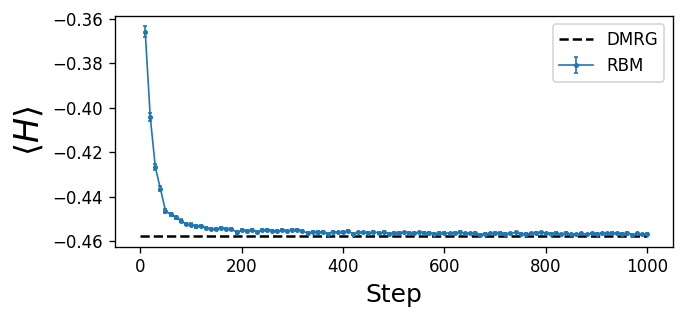

In [7]:
# Plot energy as a function of training time
fig = plt.figure(1, figsize=(6,2.5), dpi=120, facecolor='w', edgecolor='k')

energy_data = obs_evaluator["RydbergHamiltonian"]  # extract recorded energies

plt.errorbar(range(period, 1001, period), energy_data.mean, yerr=energy_data.std_error, 
             marker='o', markersize=2, linewidth=1, capsize=1,
             label="RBM")
plt.hlines(dmrg_energy, 0, epochs, linestyle="--", label="DMRG", color="k")

plt.xlabel("Step",fontsize=15)
plt.ylabel("$\\langle H \\rangle$",fontsize=20)
plt.legend(loc="best")

plt.show()